In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pydose_rt as PDRT


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [12]:
machine_config = PDRT.MachineConfig(number_of_leaf_pairs=10, tpr_20_10=0.73, mean_photon_energy_MeV=0.39)
phantom = PDRT.Phantom.from_uniform_water(shape=(185, 167, 167), spacing=(3.0, 3.0, 3.0))
beam = PDRT.Beam.create(
    gantry_angle_deg=0.0,
    number_of_leaf_pairs=10, 
    field_size_mm=(100.0, 100.0),
    iso_center=(277.5, 100.0, 251.0)
)

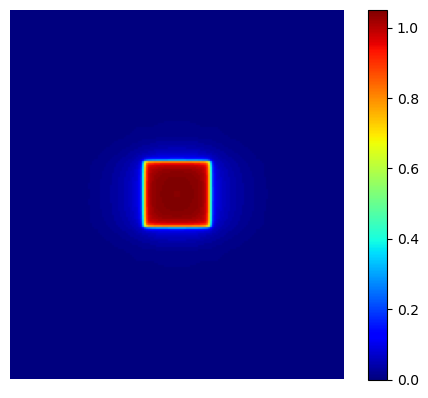

In [13]:
slice_idx = 92
ds_ref = np.load("../example_data/water_phantom.npz")["dose"] / 100
plt.imshow(ds_ref[:, 30, :], cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

In [14]:
engine = PDRT.DoseEngine(
    machine_config=machine_config,
    dose_grid_spacing=phantom.resolution,
    dose_grid_shape=ds_ref.shape,
    kernel_size=151,
    device=device,
    dtype=dtype)
phantom = phantom.to(engine.dtype).to(engine.device)
beam = beam.to(engine.device).to(engine.dtype)
dose = engine.compute_dose(beam, density_image=phantom.density_image).detach().cpu().numpy()

/home/bolo/Documents/PyDoseRT/src/pydose_rt/geometry/projections.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  leaf_widths = torch.tensor(


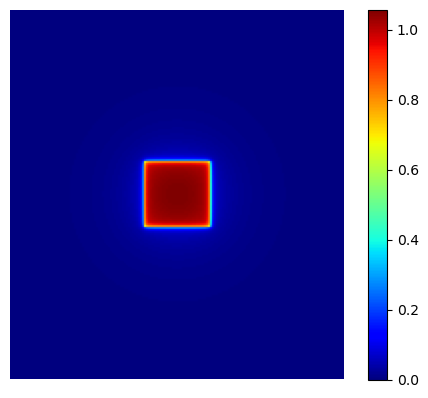

In [15]:
plt.imshow(dose[0, :, 30, :], cmap='jet') #, alpha=0.5)
plt.axis('off')
plt.colorbar()
# plt.axis('off')
plt.show()

(1, 185, 167, 167)
(185, 167, 167)


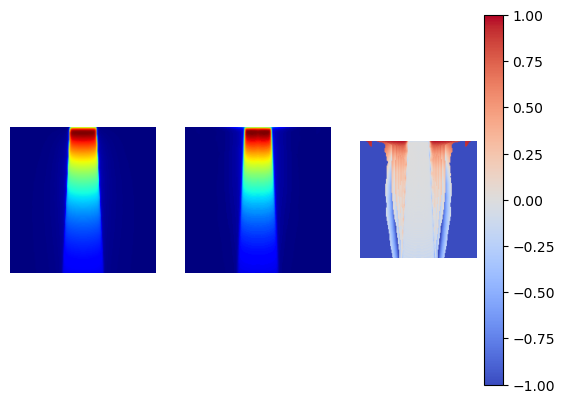

In [16]:
slice_idx = 84
print(dose.shape)
print(ds_ref.shape)

dose_plot = dose
axis = 0
slice_idx = dose_plot.shape[axis+1] // 2
plt.subplot(131)
plt.imshow(np.take(dose[0], slice_idx, axis=axis), cmap='jet')
plt.axis('off')
plt.subplot(132)
plt.imshow(np.take(ds_ref, slice_idx, axis=axis), cmap='jet')
plt.axis('off')
plt.subplot(133)
plt.imshow(np.take((ds_ref - dose[0]) / (ds_ref + 1e-10), slice_idx, axis=axis), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.axis('off')
plt.show()

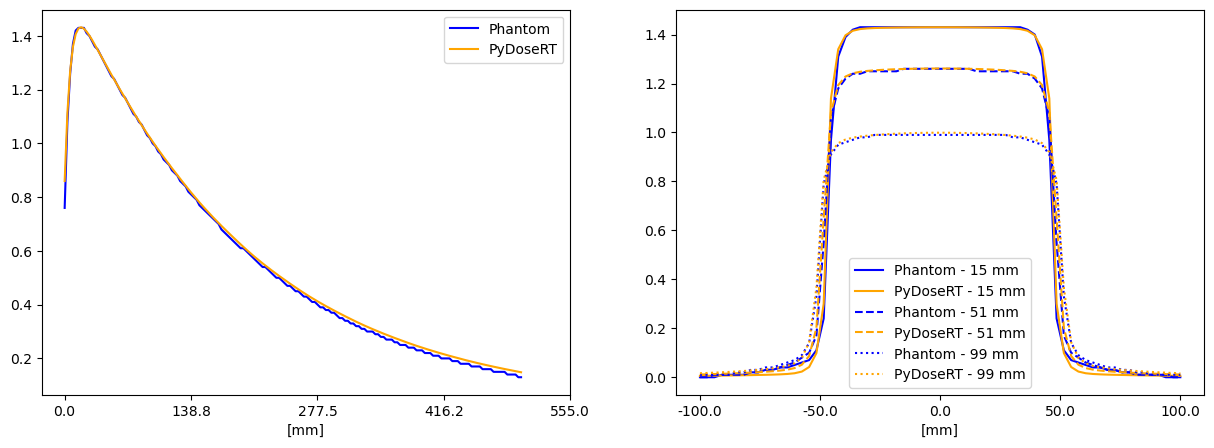

In [17]:
air_gap = 1

slice_idx = 84
depth_index = 93

x = np.linspace(0, engine.dose_grid_shape[1], engine.dose_grid_shape[1])

plt.figure(figsize=(15, 5))
# Create the plot
plt.subplot(121)
plt.plot(x, ds_ref[slice_idx, :, depth_index], label='Phantom', color='blue')
plt.plot(x, dose_plot[0, slice_idx, :, depth_index], label='PyDoseRT', color='orange')
plt.legend()

# Set x-ticks from 0 to 128, but label them as 0 to 26
num_ticks = 5
new_xticks = np.linspace(0, engine.dose_grid_shape[0], num_ticks)  # 27 points from 0 to 128
new_xtick_labels = np.round(np.linspace(0, engine.dose_grid_shape[0]*engine.dose_grid_spacing[0], num_ticks), 1)  # Corresponding labels from 0 to 26

# Apply the new ticks and labels
plt.xticks(new_xticks, new_xtick_labels)
plt.xlabel('[mm]')

plt.subplot(122)

num_ticks = 5
new_xticks = np.linspace(-100, 100,num_ticks)  # 27 points from 0 to 128
new_xtick_labels = np.round(np.linspace(-100, 100, num_ticks), 1)  # Corresponding labels from 0 to 26
x = np.linspace(-100, 100, 67)

# Create the plot
slices = [5, 17, 33]
line_styles = ['-', '--', ':']
for i in range(len(slices)):
  plt.plot(x, ds_ref[59:126, slices[i], depth_index], label=f'Phantom - {int(slices[i] * engine.dose_grid_spacing[1])} mm', color='blue', linestyle=line_styles[i])
  plt.plot(x, dose_plot[0, 59:126, slices[i], depth_index], label=f'PyDoseRT - {int(slices[i] * engine.dose_grid_spacing[1])} mm', color='orange', linestyle=line_styles[i])
plt.legend()

# Apply the new ticks and labels
plt.xticks(new_xticks, new_xtick_labels)
plt.xlabel('[mm]')

# Show the plot
plt.show()